#  1. 基于MindSpore的鸢尾花分类任务对比实验-MS1.1

## 实验介绍

本实验主要介绍如何使用MindSpore进行优化实验。共包含两个实验分别为：

- 实验一：利用不同优化器求解函数极值点实验
- 实验二：鸢尾花数据在不同优化器下的分类实验

通过分析无优化器、SGD优化器、Momentum优化器、Adam优化器模型在求极值点和分类任务下的结果 ，得到不同优化器的作用。

## 实验目的

- 掌握MindSpore中优化器的使用及其作用。
- 了解如何使用MindSpore进行SGD、Momentum、Adam优化器实验。
- 了解不同优化器原理。

## 预备知识

- 熟练使用Python。
- 具备一定的深度学习理论知识，如感知机、损失函数、优化器，训练策略等。
- 了解华为云的基本使用方法，包括[OBS（对象存储）](https://www.huaweicloud.com/product/obs.html)、[ModelArts（AI开发平台）](https://www.huaweicloud.com/product/modelarts.html)、[训练作业](https://support.huaweicloud.com/engineers-modelarts/modelarts_23_0046.html)等功能。华为云官网：https://www.huaweicloud.com
- 了解并熟悉MindSpore AI计算框架，MindSpore官网：https://www.mindspore.cn/

## 实验环境

- MindSpore 1.1.1（MindSpore版本会定期更新，本指导也会定期刷新，与版本配套）；
- 华为云ModelArts：ModelArts是华为云提供的面向开发者的一站式AI开发平台，集成了昇腾AI处理器资源池，用户可以在该平台下体验MindSpore。

### 数据集准备

#### 求函数极值点

为了评价优化器的特性，我们模拟了一个目标函数求极值过程。定义不同优化器求其极值，与目标结果比较。

目标函数Beale 公式:

$$
f(x_1,x_2)=(1.5−x_1+x_1x_2)^2+(2.25−x_1+x_1x_2^2)^2+(2.625−x_1+x_1x_2^3)^2
$$

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/Beale%27s_function.pdf/page1-1200px-Beale%27s_function.pdf.jpg" width=600 height=450>
[Image credit: Gaortizg]

方程极值点$ (x_1,  x_2) = (3,  0.5) $

我们需要通过各种不同的优化器来优化目标函数。优化器的主要目的是通过迭代找到目标函数的极小值或者极大值。常用的优化器有：SGD、Momentum、NAG、Adagrad、Adam等。

定义目标函数beale、目标函数的偏导函数dbeale_dx，并画出目标函数和极值点

目标结果 (x_1, x_2) = (3, 0.5)


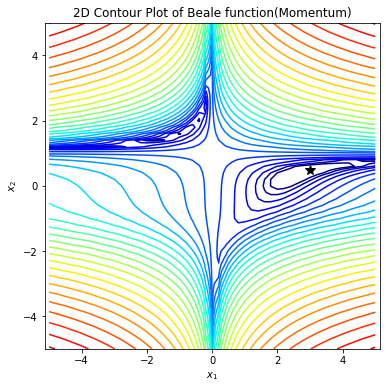

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as plt_cl  # Matplotlib的色阶条

# ------------------定义目标函数beale、目标函数的偏导函数dbeale_dx，并画出目标函数---------------------
#定义beale公式
def beale(x1,x2):
    return (1.5-x1+x1*x2)**2+(2.25-x1+x1*x2**2)**2+(2.625-x1+x1*x2**3)**2
#定义beale公式的偏导函数
def dbeale_dx(x1, x2):
    dfdx1 = 2*(1.5-x1+x1*x2)*(x2-1)+2*(2.25-x1+x1*x2**2)*(x2**2-1)+2*(2.625-x1+x1*x2**3)*(x2**3-1) # 求beale公式关于x1的偏导数
    dfdx2 = 2*(1.5-x1+x1*x2)*x1+2*(2.25-x1+x1*x2**2)*(2*x1*x2)+2*(2.625-x1+x1*x2**3)*(3*x1*x2**2) # 求beale公式关于x2的偏导数
    return dfdx1, dfdx2


# 定义画图函数
def gd_plot(x_traj):
    plt.rcParams['figure.figsize'] = [6, 6] # 窗口大小
    plt.contour(X1, X2, Y, levels=np.logspace(0, 6, 30),
                norm=plt_cl.LogNorm(), cmap=plt.cm.jet)  # 画等高线图
    plt.title('2D Contour Plot of Beale function(Momentum)') # 添加标题
    plt.xlabel('$x_1$') # x轴标签
    plt.ylabel('$x_2$') # y轴标签
    plt.axis('equal') # 设置坐标轴为正方形
    plt.plot(3, 0.5, 'k*', markersize=10) # 画出最低点
    if x_traj is not None:
        x_traj = np.array(x_traj) # 将x_traj转为数组
        plt.plot(x_traj[:, 0], x_traj[:, 1], 'k-') 
# 以x_traj的第一列为x轴坐标，第二列为y轴坐标进行画图
plt.show() # 显示图像

step_x1, step_x2 = 0.2, 0.2
X1, X2 = np.meshgrid(np.arange(-5, 5 + step_x1, step_x1),
                     np.arange(-5, 5 + step_x2, step_x2))  # 将图形从-5 到 5.2，步长为0.2 划分成网格点
Y = beale(X1, X2) # 将x1,x2坐标带入beale公式
print("目标结果 (x_1, x_2) = (3, 0.5)")
gd_plot(None) # 调用函数


## 实验步骤

### 实验一：求函数极值点实验

#### 无优化器模型训练、测试、预测

原理：无优化器训练不更新参数，不管训练多少次，模型的参数没有发生变化。模型效果与模型初始化参数关系较大。

下面是不使用优化器求解Beale 公式极值点实现。

无优化器求得极值点 (x_1, x_2) = (1.0, 1.5)


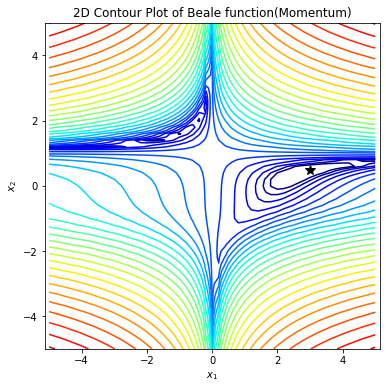

In [2]:
# ------------------------------------------------------------无优化器-------------------------------------------
#定义无优化器函数
def gd_no(df_dx, x0, conf_para=None):
    if conf_para is None:
        conf_para = {}
    conf_para.setdefault('n_iter', 1000)  # 迭代次数
    conf_para.setdefault('learning_rate', 0.001)  # 设置学习率
    x_traj = []
    x_traj.append(x0)
    v = np.zeros_like(x0)
#没有迭代更新的操作，所以，坐标没有变化
    for iter in range(1, conf_para['n_iter'] + 1):
        x_traj.append(x_traj[-1])
    return x_traj
#初始化坐标
x0 = np.array([1.0, 1.5])
conf_para_no = {'n_iter': 2000, 'learning_rate': 0.005}
#调用函数进行更新
x_traj_no = gd_no(dbeale_dx, x0, conf_para_no)
print("无优化器求得极值点 (x_1, x_2) = (%s, %s)" % (x_traj_no[-1][0], x_traj_no[-1][1]))
gd_plot(x_traj_no)


#### SGD优化器模型训练、测试、预测

梯度下降法：梯度下降（gradient descent）在机器学习中应用十分的广泛，是求解无约束优化问题最简单和最古老的方法之一。通过迭代，参数向梯度的反方向更新，直到收敛。

$$
W_{new} = W - \eta\frac{\partial J(W)}{\partial W}
$$

其中$ \frac{\partial  J(W)}{\partial W}  $ 表示损失函数 J 关于参数W的梯度；$ \eta $表示学习率；

**缺点：**

- 有可能会陷入局部最小值；
- 不会收敛，最终会一直在最小值附近波动，并不会达到最小值并停留在此；
- 下降速度慢；
- 选择合适的学习率比较困难；
- 在所有方向上统一的缩放梯度，不适用于稀疏数据；

下面是使用SGD优化器求解Beale 公式极值点实现。

SGD求得极值点 (x_1, x_2) = (2.981957257903412, 0.4954609564102124)


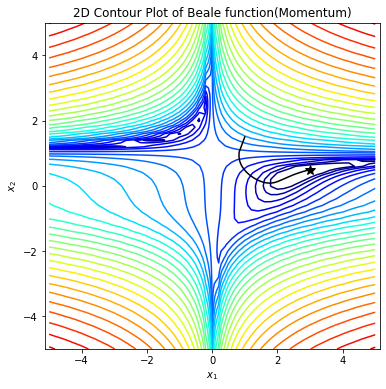

In [3]:
# ------------------------------------------------------------SGD-------------------------------------------
def gd_sgd(df_dx, x0, conf_para=None):
    if conf_para is None:
        conf_para = {}
    conf_para.setdefault('n_iter', 1000)  # 迭代次数
    conf_para.setdefault('learning_rate', 0.001)  # 设置学习率
    x_traj = []
    x_traj.append(x0)
    v = np.zeros_like(x0)
#利用梯度值对坐标进行更新
    for iter in range(1, conf_para['n_iter'] + 1):
        dfdx = np.array(df_dx(x_traj[-1][0], x_traj[-1][1]))  # 计算梯度
        v = - conf_para['learning_rate'] * dfdx  # 负的学习率*梯度值
        x_traj.append(x_traj[-1] + v)  # 添加新的x_traj
    return x_traj

x0 = np.array([1.0, 1.5])
conf_para_sgd = {'n_iter': 2000, 'learning_rate': 0.005}
x_traj_sgd = gd_sgd(dbeale_dx, x0, conf_para_sgd)
print("SGD求得极值点 (x_1, x_2) = (%s, %s)" % (x_traj_sgd[-1][0], x_traj_sgd[-1][1]))
gd_plot(x_traj_sgd)

#### Momentum优化器模型训练、测试、预测

Momentum：是动量优化法中的一种（Momentum、NAG），即使用动量(Momentum)的随机梯度下降法(SGD)，主要思想是引入一个积攒历史梯度信息的动量来加速SGD。其参数优化公式如下所示：

$$
v_{new} = \gamma v - \eta\frac{\partial J(W)}{\partial W} \\
W_{new} = W + v_{new}
$$

其中$ \frac{\partial  J(W)}{\partial W}  $ 表示损失函数 J 关于参数W的梯度；$ \eta $表示学习率；$ \gamma $表示动量的大小，一般取值为0.9。

这个算法和之前的梯度下降法(SGD)相比，唯一不同的就是多了一个$ \gamma v$。这一改动使Momentum会观察历史梯度，若当前梯度的方向与历史梯度一致（表明当前样本不太可能为异常点），则会增强这个方向的梯度；若当前梯度与历史梯方向不一致，则梯度会衰减。一种形象的解释是：我们把一个球推下山，球在下坡时积聚动量，在途中变得越来越快，γ可视为空气阻力，若球的方向发生变化，则动量会衰减。

**优点：**

- 参考了历史梯度，增加了稳定性；
- 由于引入加速动量，加快收敛速度。下降初期时，使用上一次参数更新，下降方向一致，乘上较大的$ \gamma $能够进行很好的加速；
- 还有一定摆脱局部最优的能力。下降中后期时，在局部最小值来回震荡的时候，梯度趋近于0，$ \gamma $使得更新幅度增大，跳出陷阱（局部最优）；

下面是使用Momentum优化器求解Beale 公式极值点实现。

Momentum求得极值点 (x_1, x_2) = (3.0004236971560485, 0.5001057348328146)


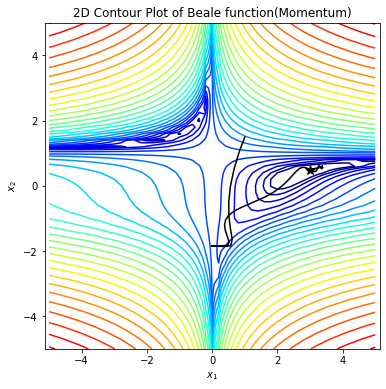

In [4]:
def gd_momentum(df_dx, x0, conf_para=None):
    if conf_para is None:
        conf_para = {}
    conf_para.setdefault('n_iter', 1000)  # 迭代次数
    conf_para.setdefault('learning_rate', 0.001)  # 设置学习率
    conf_para.setdefault('momentum', 0.9)  # 设置动量参数
    x_traj = []
    x_traj.append(x0)
    v = np.zeros_like(x0)
#套用动量优化器公式，对坐标值进行更新
    for iter in range(1, conf_para['n_iter'] + 1):
        dfdx = np.array(df_dx(x_traj[-1][0], x_traj[-1][1]))  # 计算梯度
        v = conf_para['momentum'] * v - conf_para['learning_rate'] * dfdx  # 计算更新
        x_traj.append(x_traj[-1] + v)
    return x_traj


x0 = np.array([1.0, 1.5])
conf_para_momentum = {'n_iter': 500, 'learning_rate': 0.005}
x_traj_momentum = gd_momentum(dbeale_dx, x0, conf_para_momentum)
print("Momentum求得极值点 (x_1, x_2) = (%s, %s)" % (x_traj_momentum[-1][0], x_traj_momentum[-1][1]))
gd_plot(x_traj_momentum)


#### 自适应优化器模型训练、测试、预测

自适应学习率优化算法主要有：AdaGrad算法，RMSProp算法，Adam算法以及AdaDelta算法。

**AdaGrad**

AdaGrad的基本思想是对每个变量用不同的学习率。这个学习率在一开始比较大，用于快速梯度下降。随着优化过程的进行，对于已经下降很多的变量，则减缓学习率，对于还没怎么下降的变量，则保持一个较大的学习率。其参数优化公式如下所示：

$$
G_{new} = G + (\frac{\partial J(W)}{\partial W})^2 \\
W_{new} = W - \frac{\eta}{(\sqrt{G_{new}} + \varepsilon)}\cdot\frac{\partial J(W)}{\partial W}
$$

其中$ \frac{\partial J(W)}{\partial W}  $ 表示损失函数 J 关于参数W的梯度；$ \eta $表示学习率，一般取值0.01；$ \varepsilon $是一个很小的数，防止分母为0；$G_{new}$表示了前t 步参数$W$梯度的平方累加。把沿路的Gradient的平方根，作为Regularizer。分母作为Regularizer项的工作机制如下：

1. 训练前期，梯度较小，使得Regularizer项很大，放大梯度。[激励阶段]
2. 训练后期，梯度较大，使得Regularizer项很小，缩小梯度。[惩罚阶段]

**优点：**

- 在数据分布稀疏的场景，能更好利用稀疏梯度的信息，比标准的SGD算法更有效地收敛；
- 对每个变量用不同的学习率，对输入参数学习率的依赖小，容易调节参数；

**缺点：**

- 主要缺陷来自分母项的对梯度平方不断累积，随之时间步地增加，分母项越来越大，最终导致学习率收缩到太小无法进行有效更新；

**RMSProp**

为了解决 Adagrad 学习率急剧下降问题，RMSProp保留过去梯度的微分平方数项，旨在消除梯度下降中的摆动。与Momentum的效果一样，某一维度的导数比较大，则指数加权平均就大，某一维度的导数比较小，则其指数加权平均就小，这样就保证了各维度导数都在一个量级，进而减少了摆动。允许使用一个更大的学习率η。其参数优化公式如下所示：

$$
v_{new} = \gamma\cdot v + (1 - \gamma)\cdot{(\frac{\partial J(W)}{\partial W})}^2 \\
W_{new} = W - \frac{\eta}{(\sqrt{v_{new}} + \varepsilon)}(\frac{\partial J(W)}{\partial W})
$$

其中$ \frac{\partial  J (W)}{\partial W}  $ 表示损失函数 J 关于参数W的梯度；$ \eta $表示学习率，一般取值0.001；$ \varepsilon $是一个很小的数，防止分母为0；$ \gamma $表示动量的大小,一般取值为0.9。

**Adam**

Adam算法是另一种计算每个参数的自适应学习率的方法。相当于 RMSprop + Momentum。除了像RMSprop存储了过去梯度的平方 $ v_t $ 的指数衰减平均值 ，也像 momentum 一样保持了过去梯度$ m_t $ 的指数衰减平均值。其参数优化公式如下所示：

$$
m_{new} = \beta _1 m + (1 - \beta _1)(\frac{\partial J(W)}{\partial W})
$$

$$
v_{new} = \beta _2 v + (1 - \beta _2)(\frac{\partial J(W)}{\partial W})^2
$$

由于$\frac{m_0}{v_0}$初始化为0，会导致$\frac{m_{new}}{v_{new}}$偏向于0，尤其在训练初期阶段，所以，此处需要对梯度均值$\frac{m_{new}}{v_{new}}$进行偏差纠正，降低偏差对训练初期的影响。

$$
\hat{m_{new}} = m_{new} / (1 - \beta _1) 
$$

$$
\hat{v_{new}} = v_{new} / (1 - \beta _2)
$$

$$
W_{new} = W - \eta\frac{1}{\sqrt{\hat{v_{new}}} + \varepsilon}\hat{m_{new}}
$$

其中$ \frac{\partial  J (W)}{\partial W}  $ 表示损失函数 J 关于参数W的梯度；$ \eta $表示学习率，一般取值0.001；$ \varepsilon $是一个很小的数，一般取值10e−8，防止分母为0；$ \beta _1 $ $ \beta _2 $分别表示一阶和二阶动量的大小，一般取值为$ \beta _1 = 0.9 $ $ \beta _2 = 0.99 $。

**优点**

- 能够克服AdaGrad梯度急剧减小的问题，在很多应用中都展示出优秀的学习率自适应能力；
- 实现简单，计算高效，对内存需求少；
- 参数的更新不受梯度的伸缩变换影响；
- 超参数具有很好的解释性，且通常无需调整或仅需很少的微调；
- 更新的步长能够被限制在大致的范围内（初始学习率）；
- 能自然地实现步长退火过程（自动调整学习率）；
- 很适合应用于大规模的数据及参数的场景；
- 适用于不稳定目标函数；
- 适用于梯度稀疏或梯度存在很大噪声的问题；

下面是使用自适应优化器求解Beale 公式极值点实现。

Adagrad求得极值点 (x_1, x_2) = (2.9993173156940776, 0.49982846432011524)


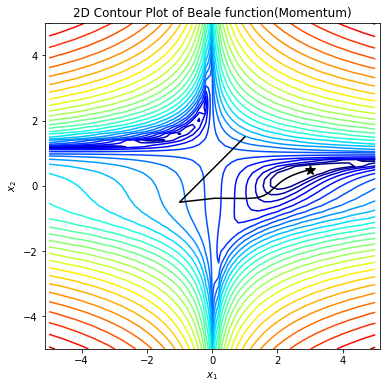

In [5]:
# ----------------------------------------------------adagrad-----------------------------
def gd_adagrad(df_dx, x0, conf_para=None):
    if conf_para is None:
        conf_para = {}
    conf_para.setdefault('n_iter', 1000)  # 迭代次数
    conf_para.setdefault('learning_rate', 0.001)  # 学习率
    conf_para.setdefault('epsilon', 1e-7)
    x_traj = []
    x_traj.append(x0)
    r = np.zeros_like(x0)
   #套用adagrad优化器公式，对参数进行更新
    for iter in range(1, conf_para['n_iter'] + 1):
        dfdx = np.array(df_dx(x_traj[-1][0], x_traj[-1][1]))
        r += dfdx ** 2
        x_traj.append(x_traj[-1] - conf_para['learning_rate'] / (np.sqrt(r) + conf_para['epsilon']) * dfdx)
    return x_traj


x0 = np.array([1.0, 1.5])
conf_para_adag = {'n_iter': 500, 'learning_rate': 2}
x_traj_adag = gd_adagrad(dbeale_dx, x0, conf_para_adag)
print("Adagrad求得极值点 (x_1, x_2) = (%s, %s)" % (x_traj_adag[-1][0], x_traj_adag[-1][1]))
gd_plot(x_traj_adag)


从结果可以看出：无优化器参数不更新，求函数极值点无效。SGD、Momentum、自适应优化器求得的极值点与目标点(3.0,  0.5)较近。SGD、Momentum、自适应优化器求解极值点方法有效。其中SGD优化器实验需要的迭代次数2000多，相比与后边Momentum优化器多迭代1500次，证明了SGD优化器收敛速度慢。从图像可以看出自适应优化器对收敛方向把握比较好。

### 实验二：鸢尾花分类实验

#### 导入MindSpore模块和辅助模块

In [6]:
import csv
import os
import time

import numpy as np
from easydict import EasyDict as edict
from matplotlib import pyplot as plt

import mindspore
from mindspore import nn
from mindspore import context
from mindspore import dataset
from mindspore.train.callback import TimeMonitor, LossMonitor
from mindspore import Tensor
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig

context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")  # 设定运行模式为静态图模式，并且运行设备为昇腾芯片

[WARNING] ME(1298:281473863018800,MainProcess):2021-03-22-01:51:06.547.351 [mindspore/_check_version.py:207] MindSpore version 1.1.1 and "te" wheel package version 1.0 does not match, reference to the match info on: https://www.mindspore.cn/install
MindSpore version 1.1.1 and "topi" wheel package version 0.6.0 does not match, reference to the match info on: https://www.mindspore.cn/install
[WARNING] ME(1298:281473863018800,MainProcess):2021-03-22-01:51:07.619.238 [mindspore/ops/operations/array_ops.py:2302] WARN_DEPRECATED: The usage of Pack is deprecated. Please use Stack.


#### 变量定义

In [7]:
#变量定义
cfg = edict({
    'data_size': 150,
    'train_size': 120,      #训练集大小
    'test_size': 30 ,       #测试集大小
    'feature_number': 4,       #输入特征数
    'num_class': 3,     #分类类别
    'batch_size': 30,   #批次大小
    'data_dir':    'iris.data',     # 数据集路径           
    'save_checkpoint_steps': 5,                 #多少步保存一次模型
    'keep_checkpoint_max': 1,                      #最多保存多少个模型
    'out_dir_no_opt':   './model_iris/no_opt',          #保存模型路径，无优化器模型
    'out_dir_sgd':   './model_iris/sgd',          #保存模型路径,SGD优化器模型
    'out_dir_momentum':   './model_iris/momentum',          #保存模型路径，momentum模型
    'out_dir_adam':   './model_iris/adam',          #保存模型路径，adam优化器模型
    'output_prefix': "checkpoint_fashion_forward"     #保存模型文件名
})


#### 读取数据并预处理

读取Iris数据集`iris.data`。

In [9]:
#鸢尾花数据集，本数据集共有150个带标签的数据
with open(cfg.data_dir) as csv_file:
    data = list(csv.reader(csv_file, delimiter=','))


共150条数据，将数据集的4个属性作为自变量X。将数据集的3个类别映射为{0, 1，2}，作为因变量Y。

In [10]:
label_map = {'setosa': 0,'versicolor': 1,'virginica':2 }
#分别获取数据中的特征值X和标签值Y
X = np.array([[float(x) for x in s[:-1]] for s in data[:cfg.data_size]], np.float32)
Y = np.array([label_map[s[-1]] for s in data[:cfg.data_size]], np.int32)

In [11]:
# 将数据集分为训练集120条，测试集30条。
train_idx = np.random.choice(cfg.data_size, cfg.train_size, replace=False)
test_idx = np.array(list(set(range(cfg.data_size)) - set(train_idx)))
X_train, Y_train = X[train_idx], Y[train_idx]
X_test, Y_test = X[test_idx], Y[test_idx]

使用MindSpore GeneratorDataset接口将numpy.ndarray类型的数据转换为 Dataset。

In [12]:
def gen_data(X_train, Y_train, epoch_size):
    #生成训练集
    XY_train = list(zip(X_train, Y_train))
    ds_train = dataset.GeneratorDataset(XY_train, ['x', 'y'])  # x, y 为列名
    #设定数据集大小
    #打乱操作并设定batchsize
    ds_train = ds_train.shuffle(buffer_size=cfg.train_size).batch(cfg.batch_size, drop_remainder=True) # buffer_size：数据集大小，drop_remainder：舍弃最后一个不完整的batch
    #生成测试集
    XY_test = list(zip(X_test, Y_test))
    ds_test = dataset.GeneratorDataset(XY_test, ['x', 'y'])
    #设定数据集大小
    #打乱操作并设定batchsize
    ds_test = ds_test.shuffle(buffer_size=cfg.test_size).batch(cfg.test_size, drop_remainder=True)
    return ds_train, ds_test

#### 定义训练、测试、预测过程

In [13]:
# 训练函数
def train(network, net_opt, ds_train, prefix, directory, print_times):
    #定义网络损失函数
    net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")  # sparse为True时对Label数据做one_hot处理，reduction支持mean和sum
    #定义模型
    model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={"acc"}) # 定义网络结构，损失函数，优化器，评估方式
    #定义损失值指标
    loss_cb = LossMonitor(per_print_times=print_times)   # 每隔 print_times 步监测一下损失值
#     loss_cb = LossMonitor(per_print_times=int(cfg.train_size / cfg.batch_size))   # 每隔4步监测一下损失值

    #设置checkpoint
    config_ck = CheckpointConfig(save_checkpoint_steps=cfg.save_checkpoint_steps,    # 每5步保存一下模型
                                 keep_checkpoint_max=cfg.keep_checkpoint_max)        # 最多保存1个模型
    ckpoint_cb = ModelCheckpoint(prefix=prefix, directory=directory, config=config_ck)  # 设置文件名，文件路径，以及checkpoint参数
    print("============== Starting Training ==============")
    #训练模型
    model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, loss_cb], dataset_sink_mode=False) # 设置训练次数，训练数据，回调函数（checkpoint和lossmonitor），Ascend是否采用下沉模式
    return model

In [14]:
class_names=['setosa', 'versicolor', 'virginica']
# 评估预测函数
def eval_predict(model, ds_test):
    # 使用测试集评估模型，打印总体准确率
    metric = model.eval(ds_test)
    print(metric)
    # 预测
    test_ = ds_test.create_dict_iterator().__next__()  # 生成测试集
    test = Tensor(test_['x'], mindspore.float32)  # 将测试集的特征转换成mindspore数据类型
    predictions = model.predict(test)  # 用predict进行预测
    predictions = predictions.asnumpy()  # 将预测值转换成numpy数组类型, predictions.shape为(30, 3)
    true_label = test_['y'].asnumpy()  # 将真实值转换成numpy数组类型
    for i in range(10):
        p_np = predictions[i, :]  # 取第i个数据的预测值
        pre_label = np.argmax(p_np)  # 取最大值的索引作为输出标签
        print('第' + str(i) + '个sample预测结果：', class_names[pre_label], '   真实结果：', class_names[true_label[i]])  # 输出预测值和真实值的对比结果

#### 无优化器训练、测试、预测

In [15]:
# --------------------------------------------------无优化器-----------------------------------
epoch_size = 20   # 训练20次
print('------------------无优化器--------------------------')
# 数据
ds_train, ds_test = gen_data(X_train, Y_train, epoch_size)  # 生成训练集和测试集
# 定义网络并训练
network = nn.Dense(cfg.feature_number, cfg.num_class)  # 定义一个全连接网络层，输入特征为4，输出类别为3
model = train(network, None, ds_train, "checkpoint_no_opt", cfg.out_dir_no_opt, print_times=4)  # 用训练集训练网络，设置网络结构，模型名称，保存路径, print_times
# 评估预测
eval_predict(model, ds_test)  # 用测试集进行预测


------------------无优化器--------------------------
============== Starting Training ==============
epoch: 1 step: 4, loss is 1.08183
epoch: 2 step: 4, loss is 1.084805
epoch: 3 step: 4, loss is 1.1019963
epoch: 4 step: 4, loss is 1.1077557
epoch: 5 step: 4, loss is 1.0723026
epoch: 6 step: 4, loss is 1.0932133
epoch: 7 step: 4, loss is 1.0905653
epoch: 8 step: 4, loss is 1.0666662
epoch: 9 step: 4, loss is 1.1148316
epoch: 10 step: 4, loss is 1.0861213
epoch: 11 step: 4, loss is 1.0883145
epoch: 12 step: 4, loss is 1.0673698
epoch: 13 step: 4, loss is 1.0759215
epoch: 14 step: 4, loss is 1.0991104
epoch: 15 step: 4, loss is 1.087214
epoch: 16 step: 4, loss is 1.0802222
epoch: 17 step: 4, loss is 1.0704713
epoch: 18 step: 4, loss is 1.0702841
epoch: 19 step: 4, loss is 1.1058722
epoch: 20 step: 4, loss is 1.0721544
{'acc': 0.4}
第0个sample预测结果： virginica    真实结果： virginica
第1个sample预测结果： virginica    真实结果： versicolor
第2个sample预测结果： virginica    真实结果： versicolor
第3个sample预测结果： virginica    真

In [16]:
import os
os.listdir('.')
os.listdir('./model_iris/no_opt')  # 查看保存的模型

['checkpoint_no_opt-graph.meta', 'checkpoint_no_opt-20_4.ckpt']

#### SGD优化器模型训练、测试、预测

In [17]:
# ---------------------------------------------------SGD-------------------------------------
epoch_size = 300  # 训练300次
lr = 0.01
print('-------------------SGD优化器-----------------------')
# 数据
ds_train, ds_test = gen_data(X_train, Y_train, epoch_size) # 生成训练集和测试集
# 定义网络并训练、测试、预测
network = nn.Dense(cfg.feature_number, cfg.num_class)  # 定义一个全连接网络层，输入特征为4，输出类别为3
net_opt = nn.SGD(network.trainable_params(), lr)  # 用SGD优化器进行优化 
model = train(network, net_opt, ds_train, "checkpoint_sgd", cfg.out_dir_sgd, 40)  # 用训练集训练网络，设置网络结构，优化器，模型名称，保存路径, print_times
# 评估预测
eval_predict(model, ds_test) # 用测试集进行预测     


-------------------SGD优化器-----------------------
============== Starting Training ==============
epoch: 10 step: 4, loss is 0.86795694
epoch: 20 step: 4, loss is 0.76136506
epoch: 30 step: 4, loss is 0.6700876
epoch: 40 step: 4, loss is 0.6194864
epoch: 50 step: 4, loss is 0.6602658
epoch: 60 step: 4, loss is 0.5124374
epoch: 70 step: 4, loss is 0.42643043
epoch: 80 step: 4, loss is 0.5787906
epoch: 90 step: 4, loss is 0.49911737
epoch: 100 step: 4, loss is 0.49278972
epoch: 110 step: 4, loss is 0.45104486
epoch: 120 step: 4, loss is 0.4219075
epoch: 130 step: 4, loss is 0.48353016
epoch: 140 step: 4, loss is 0.38932514
epoch: 150 step: 4, loss is 0.45380622
epoch: 160 step: 4, loss is 0.3846082
epoch: 170 step: 4, loss is 0.29295638
epoch: 180 step: 4, loss is 0.40212142
epoch: 190 step: 4, loss is 0.40266603
epoch: 200 step: 4, loss is 0.37494308
epoch: 210 step: 4, loss is 0.3486436
epoch: 220 step: 4, loss is 0.4167988
epoch: 230 step: 4, loss is 0.34158444
epoch: 240 step: 4, loss

In [18]:
os.listdir('./model_iris/sgd') # 查看保存的模型

['checkpoint_sgd-graph.meta', 'checkpoint_sgd-300_4.ckpt']

#### Momentum优化器模型训练、测试、预测

In [19]:
# ----------------------------------------------------Momentum-------------------------------
epoch_size = 20  # 训练20次
lr = 0.01  # 学习率为0.01
print('-------------------Momentum优化器-----------------------')
# 数据
ds_train, ds_test = gen_data(X_train, Y_train, epoch_size)  # 生成训练集和测试集
# 定义网络并训练
network = nn.Dense(cfg.feature_number, cfg.num_class) # 定义一个全连接网络层，输入特征为4，输出类别为3
net_opt = nn.Momentum(network.trainable_params(), lr, 0.9)   # 用 momentum 优化器进行优化，学习率为0.01，动量大小为0.9
model = train(network, net_opt, ds_train, "checkpoint_momentum", cfg.out_dir_momentum, 4)  # 用训练集训练网络，设置网络结构，优化器，模型名称，保存路径, print_times
# 评估预测
eval_predict(model, ds_test)  # 用测试集进行预测  


-------------------Momentum优化器-----------------------
============== Starting Training ==============
epoch: 1 step: 4, loss is 1.0456764
epoch: 2 step: 4, loss is 0.9358957
epoch: 3 step: 4, loss is 0.84239113
epoch: 4 step: 4, loss is 0.72849303
epoch: 5 step: 4, loss is 0.6306475
epoch: 6 step: 4, loss is 0.59610367
epoch: 7 step: 4, loss is 0.530419
epoch: 8 step: 4, loss is 0.5638479
epoch: 9 step: 4, loss is 0.47823143
epoch: 10 step: 4, loss is 0.46555394
epoch: 11 step: 4, loss is 0.49670792
epoch: 12 step: 4, loss is 0.5009627
epoch: 13 step: 4, loss is 0.45189294
epoch: 14 step: 4, loss is 0.45233986
epoch: 15 step: 4, loss is 0.39280808
epoch: 16 step: 4, loss is 0.34712094
epoch: 17 step: 4, loss is 0.40795138
epoch: 18 step: 4, loss is 0.38752627
epoch: 19 step: 4, loss is 0.383623
epoch: 20 step: 4, loss is 0.40174365
{'acc': 0.7666666666666667}
第0个sample预测结果： versicolor    真实结果： versicolor
第1个sample预测结果： setosa    真实结果： setosa
第2个sample预测结果： virginica    真实结果： virginica


In [20]:
os.listdir('./model_iris/momentum') # 查看保存的模型

['checkpoint_momentum-graph.meta', 'checkpoint_momentum-20_4.ckpt']

#### Adam优化器模型训练、测试、预测

In [21]:
# ----------------------------------------------------Adam-----------------------------------
epoch_size = 15  # 训练15次
lr = 0.1  # 学习率为0.1, 动态学习率
print('------------------Adam优化器--------------------------')
# 数据
ds_train, ds_test = gen_data(X_train, Y_train, epoch_size)  # 生成训练集和测试集
# 定义网络并训练
network = nn.Dense(cfg.feature_number, cfg.num_class)  # 定义一个全连接网络层，输入特征为4，输出类别为3
net_opt = nn.Adam(network.trainable_params(), learning_rate=lr)  # 用 Adam 优化器进行优化，学习率为0.1
model = train(network, net_opt, ds_train, "checkpoint_adam", cfg.out_dir_adam, 4)  # 用训练集训练网络，设置网络结构，优化器，模型名称，保存路径, print_times
# 评估预测
eval_predict(model, ds_test)


------------------Adam优化器--------------------------
============== Starting Training ==============
epoch: 1 step: 4, loss is 0.89272285
epoch: 2 step: 4, loss is 0.94023526
epoch: 3 step: 4, loss is 0.6061347
epoch: 4 step: 4, loss is 0.637635
epoch: 5 step: 4, loss is 0.42069417
epoch: 6 step: 4, loss is 0.45176962
epoch: 7 step: 4, loss is 0.4375511
epoch: 8 step: 4, loss is 0.34328005
epoch: 9 step: 4, loss is 0.41128898
epoch: 10 step: 4, loss is 0.32983655
epoch: 11 step: 4, loss is 0.29467988
epoch: 12 step: 4, loss is 0.32995018
epoch: 13 step: 4, loss is 0.3085513
epoch: 14 step: 4, loss is 0.34945184
epoch: 15 step: 4, loss is 0.2470425
{'acc': 0.9333333333333333}
第0个sample预测结果： setosa    真实结果： setosa
第1个sample预测结果： virginica    真实结果： virginica
第2个sample预测结果： setosa    真实结果： setosa
第3个sample预测结果： versicolor    真实结果： versicolor
第4个sample预测结果： setosa    真实结果： setosa
第5个sample预测结果： virginica    真实结果： virginica
第6个sample预测结果： virginica    真实结果： virginica
第7个sample预测结果： virginica 

In [22]:
os.listdir('./model_iris/adam') # 查看保存的模型

['checkpoint_adam-graph.meta', 'checkpoint_adam-15_4.ckpt']

**结果分析：** 从无优化器、SGD、momentum、adam优化器的loss上看：

1. 无优化器训练loss基本没有发生变化，测试结果效果差。多运行几次发现结果偏差太大，学员可以自己尝试。
2. SGD优化器loss下降速度很慢，而且在接近收敛处loss下降非常缓慢。增大学习率，减少迭代次数，会出现收敛到局部最优解的情况，学员可以自己尝试。
3. Momentum优化器loss下降速度较快，充分说明Momentum优化器改进了SGD收敛速度慢的问题。改变参数，比较不同学习率和迭代次数的结果，会发现该优化器稳定性很强，学习率容易选择。相比于SGD优化器容易调参。
4. adam优化器loss下降速度最快快，只需要15 epoch就可以达到收敛。改变模型学习率多跑几次，会发现，adam优化器可以适应不用的学习率，容易调节参数。

## 实验小结

本实验目的是使用MindSpore对比不同优化器算法，通过比较不同优化器实验结果，得到如下结论：

- 无优化器条件训练，不更新参数，训练loss基本不变。模型与初始化参数关系大，随机性较强，效果差，不适合应用；
- 有优化器条件下训练，更新模型参数。训练loss改变；
- SGD优化器收敛速度慢，参数不容易调节；
- Momentum优化器是SGD加入历史梯度动量，增加了稳定性，收敛速度有明显提高，参数较SGD容易调节；
- Adam优化器是 RMSprop + Momentum。可以适应不同学习率，可以自动为不同参数调节学习率。稳定性高，参数容易调节；